In [1]:
# Importando bibliotecas necessárias
import json
import math
import numpy as np
import random
import os
from IPython.display import display

class City:
    """Classe que representa uma cidade com suas informações"""
    def __init__(self, name, state, latitude, longitude, population):
        self.name = name
        self.state = state
        self.latitude = float(latitude)
        self.longitude = float(longitude)
        self.population = int(population)

class CityNetwork:
    """Rede de cidades conectadas por uma distância máxima"""
    def __init__(self, cities, adjacency_list, threshold_km):
        self.cities = cities
        self.adjacency_list = adjacency_list
        self.threshold_km = threshold_km

def load_cities(filepath):
    """Carrega dados de cidades de um arquivo JSON"""
    with open(filepath, 'r') as file:
        data = json.load(file)
    
    cities = []
    for city_data in data:
        name = city_data["city"]
        state = city_data["state"]
        latitude = city_data["latitude"]
        longitude = city_data["longitude"]
        population = city_data["population"]
        
        cities.append(City(name, state, latitude, longitude, population))
    
    return cities

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calcula a distância entre dois pontos na Terra usando a fórmula de Haversine"""
    # Raio da Terra em quilômetros
    R = 6371.0
    
    # Converter graus para radianos
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    
    # Diferenças
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    # Fórmula de Haversine
    a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = R * c
    
    return distance  # Retorna distância em quilômetros

def distance_between_cities(city1, city2):
    """Calcula distância entre duas cidades"""
    return haversine_distance(
        city1.latitude, city1.longitude, 
        city2.latitude, city2.longitude
    )

def create_distance_matrix(cities):
    """Cria uma matriz de distâncias entre todas as cidades"""
    n = len(cities)
    distances = np.zeros((n, n))
    
    # Calcula distâncias entre todos os pares de cidades
    for i in range(n):
        for j in range(i+1, n):
            dist = distance_between_cities(cities[i], cities[j])
            # Armazena distância em ambas as posições (matriz simétrica)
            distances[i, j] = dist
            distances[j, i] = dist
            
    return distances

def build_city_network(cities, threshold_km):
    """Constrói uma rede de cidades conectadas dentro de uma distância limite"""
    n = len(cities)
    adjacency_list = [[] for _ in range(n)]
    
    # Verifica todos os pares de cidades
    for i in range(n):
        for j in range(i+1, n):
            if distance_between_cities(cities[i], cities[j]) <= threshold_km:
                adjacency_list[i].append(j)
                adjacency_list[j].append(i)  # Grafo não-direcionado
                
    return CityNetwork(cities, adjacency_list, threshold_km)

def get_connected_cities(network, city_index):
    """Obtém lista de cidades conectadas à cidade especificada"""
    return network.adjacency_list[city_index]



In [4]:

# Carrega dados das cidades
data_path = "data/cities.json"  # Ajuste o caminho conforme necessário
cities = load_cities(data_path)
print(f"Carregadas {len(cities)} cidades.")

# Imprime dados de exemplo para verificar se funciona
print("\nPrimeiras 5 cidades:")
for i in range(min(5, len(cities))):
    city = cities[i]
    print(f"{city.name}: lat {city.latitude}, long {city.longitude}, população {city.population}")

# Exemplo de cálculo de distância entre duas cidades
if len(cities) >= 2:
    ny = cities[0]  # Nova York é a primeira cidade na lista
    la = cities[1]  # Los Angeles é a segunda cidade
    dist = distance_between_cities(ny, la)
    print(f"\nDistância entre {ny.name} e {la.name} é {dist:.2f} quilômetros")
    
# Cria matriz de distâncias
distance_matrix = create_distance_matrix(cities)
print(f"\nCriada matriz de distâncias com tamanho {distance_matrix.shape}")

# Calcula tamanho de memória
num_cities = len(cities)
matrix_bytes = num_cities * num_cities * 8
matrix_kb = matrix_bytes / 1024
matrix_mb = matrix_kb / 1024
print(f"Tamanho da matriz: {matrix_bytes:.0f} bytes ≈ {matrix_kb:.2f} KB ≈ {matrix_mb:.2f} MB")

# Obtém a cidade mais próxima de Nova York
if len(cities) >= 2:
    new_york_dist = distance_matrix[0, :]
    # Seleciona todas exceto Nova York
    cities_except_ny = new_york_dist[1:]
    closest_city_index = np.argmin(cities_except_ny) + 1  # +1 porque excluímos índice 0
    closest_city = cities[closest_city_index]
    print(f"\nCidade mais próxima de Nova York é {closest_city.name} com distância de {new_york_dist[closest_city_index]:.2f} km")
    
    # Obtém a cidade mais distante de Nova York
    farthest_city_index = np.argmax(cities_except_ny) + 1  # +1 porque excluímos índice 0
    farthest_city = cities[farthest_city_index]
    print(f"Cidade mais distante de Nova York é {farthest_city.name} com distância de {new_york_dist[farthest_city_index]:.2f} km")

# Constrói rede de cidades (conexões entre cidades em até 200km)
threshold_km = 200.0
print(f"\nConstruindo rede de cidades com limite de {threshold_km} km...")
city_network = build_city_network(cities, threshold_km)

# Exemplo: Encontrar cidades conectadas a Nova York
if len(cities) >= 1:
    ny_connections = get_connected_cities(city_network, 0)
    print(f"\nCidades dentro de {threshold_km} km de Nova York:")
    if not ny_connections:
        print("  Nenhuma")
    else:
        for idx in ny_connections:
            print(f"  {cities[idx].name} ({distance_matrix[0, idx]:.1f} km)")

# Exemplo: Gerar um caminho aleatório a partir de Nova York com profundidade variável
if len(cities) >= 6:
    start_city_index = 0  # Nova York
    path_length = 15
    path = [start_city_index]
    path_distance = 0.0
    
    for _ in range(path_length):
        current_city_index = path[-1]
        next_cities = get_connected_cities(city_network, current_city_index)
        if not next_cities:
            break
        next_city_index = random.choice(next_cities)
        path.append(next_city_index)
        path_distance += distance_matrix[current_city_index, next_city_index]
    
    print(f"\nCaminho aleatório a partir de Nova York (índice {start_city_index}) com profundidade {path_length}:")
    for idx in path:
        print(f"  {cities[idx].name}")
        
    print(f"Distância total: {path_distance:.2f} km")



Carregadas 1000 cidades.

Primeiras 5 cidades:
New York: lat 40.7127837, long -74.0059413, população 8405837
Los Angeles: lat 34.0522342, long -118.2436849, população 3884307
Chicago: lat 41.8781136, long -87.6297982, população 2718782
Houston: lat 29.7604267, long -95.3698028, população 2195914
Philadelphia: lat 39.9525839, long -75.1652215, população 1553165

Distância entre New York e Los Angeles é 3935.75 quilômetros

Criada matriz de distâncias com tamanho (1000, 1000)
Tamanho da matriz: 8000000 bytes ≈ 7812.50 KB ≈ 7.63 MB

Cidade mais próxima de Nova York é Hoboken com distância de 4.12 km
Cidade mais distante de Nova York é Honolulu com distância de 7981.78 km

Construindo rede de cidades com limite de 200.0 km...

Cidades dentro de 200.0 km de Nova York:
  Philadelphia (129.6 km)
  Newark (14.3 km)
  Jersey City (6.3 km)
  Yonkers (25.9 km)
  Springfield (194.4 km)
  Bridgeport (86.1 km)
  Paterson (26.6 km)
  New Haven (112.1 km)
  Elizabeth (18.1 km)
  Stamford (54.6 km)
  H

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import MaxNLocator

def plot_distance_distribution(distance_matrix):
    """
    Cria um histograma da distribuição de distâncias entre todas as cidades
    """
    # Extrair as distâncias da matriz (apenas o triângulo superior para evitar duplicação)
    n = distance_matrix.shape[0]
    distances = []
    for i in range(n):
        for j in range(i+1, n):
            if distance_matrix[i, j] > 0:  # Ignorar distâncias zero (mesma cidade)
                distances.append(distance_matrix[i, j])
    
    plt.figure(figsize=(12, 6))
    
    # Histograma
    plt.subplot(1, 2, 1)
    plt.hist(distances, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    plt.title('Distribuição de Distâncias entre Cidades')
    plt.xlabel('Distância (km)')
    plt.ylabel('Frequência')
    plt.grid(alpha=0.3)
    
    # Adicionar linhas verticais para possíveis thresholds
    thresholds = [200, 500, 1000, 2000]
    colors = ['red', 'orange', 'green', 'purple']
    
    for threshold, color in zip(thresholds, colors):
        plt.axvline(x=threshold, color=color, linestyle='--', 
                   label=f'Threshold: {threshold} km')
    
    # Calcular porcentagens de conexões para cada threshold
    for threshold, color in zip(thresholds, colors):
        percentage = sum(1 for d in distances if d <= threshold) / len(distances) * 100
        plt.text(threshold + 50, plt.gca().get_ylim()[1] * 0.9, 
                f'{percentage:.1f}%', color=color, fontweight='bold')
    
    plt.legend()
    
    # Box plot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=distances, color='steelblue')
    plt.title('Box Plot de Distâncias')
    plt.xlabel('Distância (km)')
    plt.grid(alpha=0.3, axis='y')
    
    # Adicionar estatísticas no box plot
    stats = {
        'Min': np.min(distances),
        'Q1': np.percentile(distances, 25),
        'Mediana': np.median(distances),
        'Q3': np.percentile(distances, 75),
        'Max': np.max(distances),
        'Média': np.mean(distances)
    }
    
    stat_text = '\n'.join([f'{k}: {v:.1f} km' for k, v in stats.items()])
    plt.text(plt.gca().get_xlim()[1] * 0.7, plt.gca().get_ylim()[0] * 0.9, 
             stat_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    plt.show()

def plot_threshold_network_stats(distance_matrix, max_threshold=5000, steps=20):
    """
    Cria gráficos mostrando como o número de conexões e a conectividade da rede 
    mudam com diferentes valores de threshold
    """
    n = distance_matrix.shape[0]
    thresholds = np.linspace(0, max_threshold, steps)
    avg_connections = []
    connected_cities_pct = []
    
    for threshold in thresholds:
        connections = 0
        cities_with_connections = 0
        
        for i in range(n):
            city_connections = sum(1 for j in range(n) if i != j and distance_matrix[i, j] <= threshold)
            connections += city_connections
            if city_connections > 0:
                cities_with_connections += 1
        
        avg_connections.append(connections / n)
        connected_cities_pct.append(cities_with_connections / n * 100)
    
    plt.figure(figsize=(12, 5))
    
    # Gráfico de conexões médias
    plt.subplot(1, 2, 1)
    plt.plot(thresholds, avg_connections, 'o-', color='teal')
    plt.title('Conexões Médias por Cidade vs. Threshold')
    plt.xlabel('Threshold de Distância (km)')
    plt.ylabel('Média de Conexões por Cidade')
    plt.grid(alpha=0.3)
    plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=5))
    
    # Destacar alguns thresholds importantes
    key_thresholds = [200, 500, 1000, 2000]
    for threshold in key_thresholds:
        idx = np.abs(thresholds - threshold).argmin()
        plt.plot(threshold, avg_connections[idx], 'o', ms=8, 
                color='red', label=f'{threshold} km: {avg_connections[idx]:.1f} conexões')
        plt.text(threshold, avg_connections[idx] + 1, f'{avg_connections[idx]:.1f}', 
                ha='center', fontweight='bold')
    
    # Gráfico de cidades conectadas
    plt.subplot(1, 2, 2)
    plt.plot(thresholds, connected_cities_pct, 'o-', color='darkblue')
    plt.title('Porcentagem de Cidades Conectadas vs. Threshold')
    plt.xlabel('Threshold de Distância (km)')
    plt.ylabel('% de Cidades com pelo menos 1 conexão')
    plt.grid(alpha=0.3)
    plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=5))
    
    # Destacar alguns thresholds importantes
    for threshold in key_thresholds:
        idx = np.abs(thresholds - threshold).argmin()
        plt.plot(threshold, connected_cities_pct[idx], 'o', ms=8, 
                color='red', label=f'{threshold} km')
        plt.text(threshold, connected_cities_pct[idx] + 1, f'{connected_cities_pct[idx]:.1f}%', 
                ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

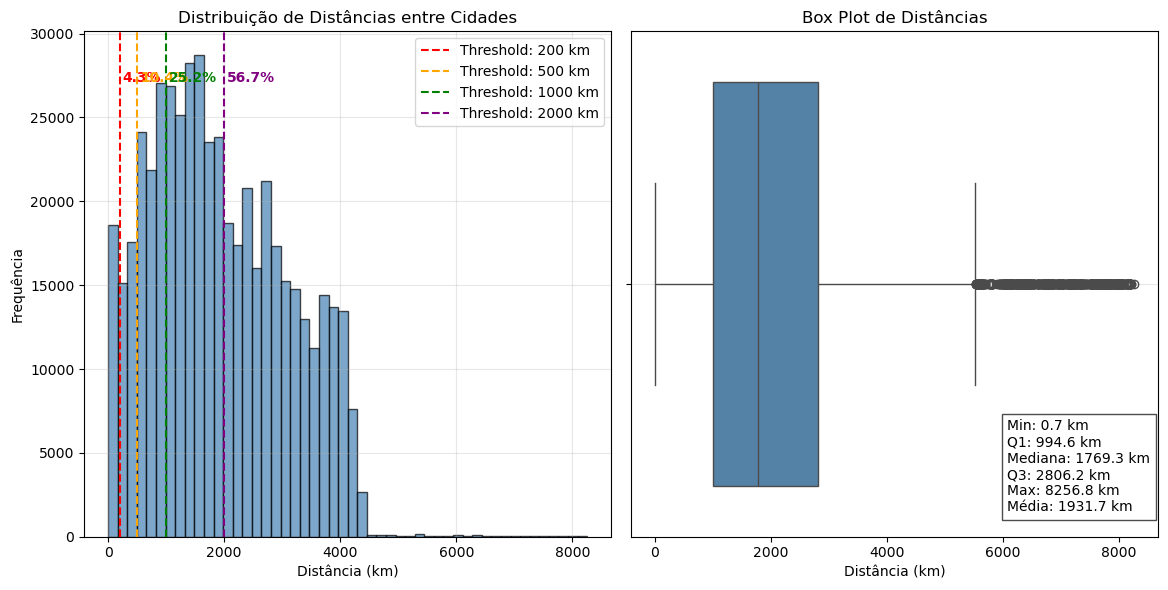

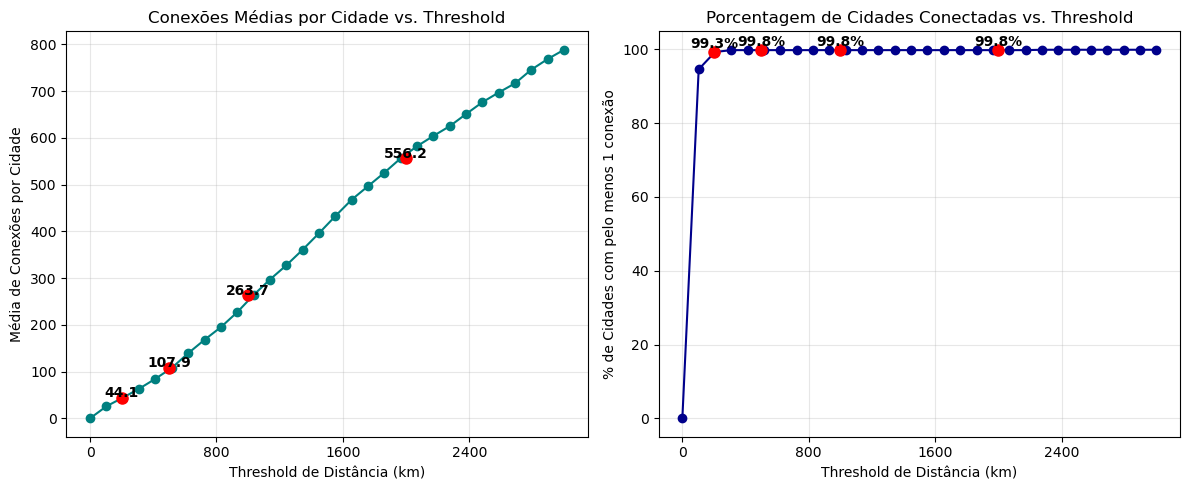

In [6]:
# Depois de criar a matriz de distâncias
plot_distance_distribution(distance_matrix)
plot_threshold_network_stats(distance_matrix, max_threshold=3000, steps=30)

In [11]:
def find_minimum_full_connectivity_threshold(distance_matrix):
    """
    Encontra o menor threshold onde todas as cidades têm pelo menos uma conexão
    """
    n = distance_matrix.shape[0]
    
    # Remover as diagonais (distâncias de cidade para ela mesma)
    distances = []
    for i in range(n):
        city_min_distance = float('inf')
        for j in range(n):
            if i != j:  # Não considerar a distância para si mesma
                city_min_distance = min(city_min_distance, distance_matrix[i, j])
        distances.append(city_min_distance)
    
    # O threshold mínimo para conectividade total é a maior das distâncias mínimas
    # (ou seja, a distância mínima para a cidade mais isolada)
    min_threshold = max(distances)
    
    # Identificar qual é a cidade mais isolada
    most_isolated_idx = np.argmax(distances)
    
    return min_threshold, most_isolated_idx

In [12]:
min_threshold, isolated_city_idx = find_minimum_full_connectivity_threshold(distance_matrix)
print(f"Raio mínimo para que todas as cidades estejam conectadas: {min_threshold:.2f} km")
print(f"A cidade mais isolada é {cities[isolated_city_idx].name}, que precisa de pelo menos {min_threshold:.2f} km para conectar-se")

# Encontrar com qual cidade esta cidade se conecta primeiro
second_city_idx = np.argmin([
    distance_matrix[isolated_city_idx, j] if isolated_city_idx != j else float('inf') 
    for j in range(len(cities))
])
print(f"A primeira conexão dela seria com {cities[second_city_idx].name}, a {distance_matrix[isolated_city_idx, second_city_idx]:.2f} km de distância")

Raio mínimo para que todas as cidades estejam conectadas: 3842.71 km
A cidade mais isolada é Honolulu, que precisa de pelo menos 3842.71 km para conectar-se
A primeira conexão dela seria com Pacifica, a 3842.71 km de distância


In [13]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle

def plot_cities_map(cities, isolated_city_idx=None, min_threshold=None, second_city_idx=None):
    """
    Cria um mapa 2D das cidades usando suas coordenadas de latitude e longitude
    
    Args:
        cities: Lista de objetos City
        isolated_city_idx: Índice da cidade mais isolada (opcional)
        min_threshold: Raio mínimo para conectividade total (opcional)
        second_city_idx: Índice da cidade mais próxima à cidade isolada (opcional)
    """
    # Extrair latitudes e longitudes
    lats = [city.latitude for city in cities]
    longs = [city.longitude for city in cities]
    
    # Extrair populações e normalizá-las para tamanhos de pontos (escala logarítmica)
    populations = np.array([city.population for city in cities])
    min_pop, max_pop = populations.min(), populations.max()
    
    # Normalizar populações para tamanhos de pontos entre 10 e 100
    min_size, max_size = 10, 100
    point_sizes = min_size + (max_size - min_size) * np.log(populations) / np.log(max_pop)
    
    # Criar o gráfico
    plt.figure(figsize=(12, 8))
    
    # Plotar todas as cidades como pontos
    sc = plt.scatter(longs, lats, s=point_sizes, alpha=0.6, c='blue', edgecolor='black', label='Cidades')
    
    # Destacar Nova York
    ny_idx = 0  # Nova York é a primeira cidade na lista
    plt.scatter(longs[ny_idx], lats[ny_idx], s=point_sizes[ny_idx]*1.5, 
                c='red', edgecolor='black', label='Nova York')
    plt.annotate('Nova York', (longs[ny_idx], lats[ny_idx]), 
                 xytext=(10, 10), textcoords='offset points', fontsize=12)
    
    # Se fornecidos, destacar a cidade mais isolada e sua conexão
    if isolated_city_idx is not None:
        plt.scatter(longs[isolated_city_idx], lats[isolated_city_idx], 
                    s=point_sizes[isolated_city_idx]*1.5, c='purple', edgecolor='black',
                    label=f'Cidade mais isolada: {cities[isolated_city_idx].name}')
        plt.annotate(cities[isolated_city_idx].name, 
                     (longs[isolated_city_idx], lats[isolated_city_idx]),
                     xytext=(10, -15), textcoords='offset points', fontsize=12)
        
        # Se fornecido, desenhar uma linha para a cidade mais próxima
        if second_city_idx is not None:
            plt.plot([longs[isolated_city_idx], longs[second_city_idx]], 
                     [lats[isolated_city_idx], lats[second_city_idx]], 
                     'k-', alpha=0.5, linewidth=1.5)
            plt.scatter(longs[second_city_idx], lats[second_city_idx], 
                        s=point_sizes[second_city_idx]*1.5, c='green', edgecolor='black',
                        label=f'Cidade mais próxima: {cities[second_city_idx].name}')
            plt.annotate(cities[second_city_idx].name, 
                         (longs[second_city_idx], lats[second_city_idx]),
                         xytext=(10, 10), textcoords='offset points', fontsize=12)
            
            # Se fornecido, desenhar o círculo com o raio mínimo
            if min_threshold is not None:
                # Converter o raio de km para graus aproximadamente (aproximação para visualização)
                # Essa é uma aproximação grosseira, já que graus de longitude não correspondem 
                # diretamente a distâncias lineares
                # Usar 111.32 km por grau de latitude como aproximação
                radius_deg = min_threshold / 111.32
                
                # Desenhar círculos aproximados em torno da cidade isolada
                circle = Circle((longs[isolated_city_idx], lats[isolated_city_idx]), 
                               radius_deg, fill=False, color='purple', linestyle='--', 
                               alpha=0.5, label=f'Raio de {min_threshold:.0f} km')
                plt.gca().add_patch(circle)
    
    # Adicionar detalhes ao gráfico
    plt.title('Mapa de Cidades dos EUA', fontsize=16)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend(loc='lower right')
    
    # Ajustar limites do gráfico para focar nos EUA
    plt.xlim(min(longs) - 5, max(longs) + 5)
    plt.ylim(min(lats) - 3, max(lats) + 3)
    
    # Adicionar nota sobre o tamanho dos pontos
    plt.figtext(0.01, 0.01, 'Tamanho do ponto proporcional à população da cidade (escala logarítmica)', 
                fontsize=10, alpha=0.7)
    
    plt.tight_layout()
    plt.show()

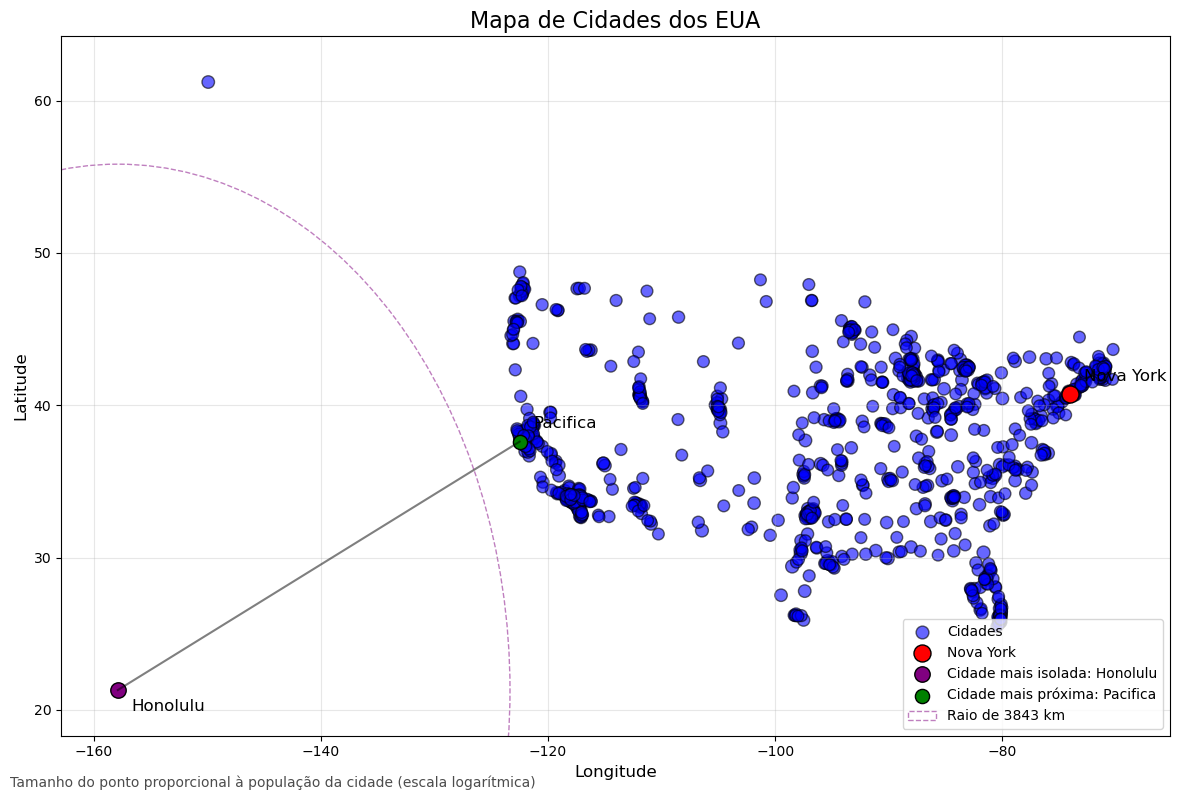

In [14]:
# Chamada da função para visualizar as cidades
plot_cities_map(cities, isolated_city_idx, min_threshold, second_city_idx)

In [17]:
def analyze_network_without_isolated_city(cities, distance_matrix, isolated_city_idx):
    """
    Analisa a rede de cidades após remover a cidade mais isolada
    
    Args:
        cities: Lista de objetos City
        distance_matrix: Matriz de distâncias original
        isolated_city_idx: Índice da cidade isolada a ser removida
    """
    # Criar novas listas sem a cidade isolada
    new_cities = [city for i, city in enumerate(cities) if i != isolated_city_idx]
    
    # Criar nova matriz de distâncias (removendo a linha e coluna da cidade isolada)
    n = distance_matrix.shape[0]
    mask = np.ones(n, dtype=bool)
    mask[isolated_city_idx] = False
    new_distance_matrix = distance_matrix[mask][:, mask]
    
    # Encontrar o novo threshold mínimo
    new_min_threshold, new_isolated_idx = find_minimum_full_connectivity_threshold(new_distance_matrix)
    
    # Identificar a nova cidade isolada
    new_isolated_city = new_cities[new_isolated_idx]
    
    # Encontrar a cidade mais próxima da nova cidade isolada
    new_second_idx = np.argmin([
        new_distance_matrix[new_isolated_idx, j] if new_isolated_idx != j else float('inf') 
        for j in range(len(new_cities))
    ])
    
    # Imprimir resultados
    print(f"Após remover {cities[isolated_city_idx].name}:")
    print(f"Novo raio mínimo para conectividade total: {new_min_threshold:.2f} km")
    print(f"Nova cidade mais isolada: {new_isolated_city.name}")
    print(f"Primeira conexão da nova cidade isolada: {new_cities[new_second_idx].name} " 
          f"a {new_distance_matrix[new_isolated_idx, new_second_idx]:.2f} km")
          
    # Encontrar a redução no raio mínimo
    reduction = min_threshold - new_min_threshold
    print(f"Redução no raio mínimo: {reduction:.2f} km ({(reduction/min_threshold)*100:.1f}%)")
    
    # Plotar o novo mapa
    print("\nMapa original com a cidade isolada:")
    plot_cities_map(cities, isolated_city_idx, min_threshold, second_city_idx)
    
    print("\nNovo mapa após remover a cidade isolada:")
    
    # Converter índices do novo mapa para corresponder aos índices originais
    # (para visualização consistente)
    orig_new_isolated_idx = [i for i in range(len(cities)) if i != isolated_city_idx][new_isolated_idx]
    orig_new_second_idx = [i for i in range(len(cities)) if i != isolated_city_idx][new_second_idx]
    
    plot_cities_map(cities, 
                    isolated_city_idx=orig_new_isolated_idx, 
                    min_threshold=new_min_threshold, 
                    second_city_idx=orig_new_second_idx)
    
    return new_cities, new_distance_matrix, new_min_threshold, new_isolated_idx

Após remover Honolulu:
Novo raio mínimo para conectividade total: 2204.27 km
Nova cidade mais isolada: Anchorage
Primeira conexão da nova cidade isolada: Bellingham a 2204.27 km
Redução no raio mínimo: 1638.43 km (42.6%)

Mapa original com a cidade isolada:


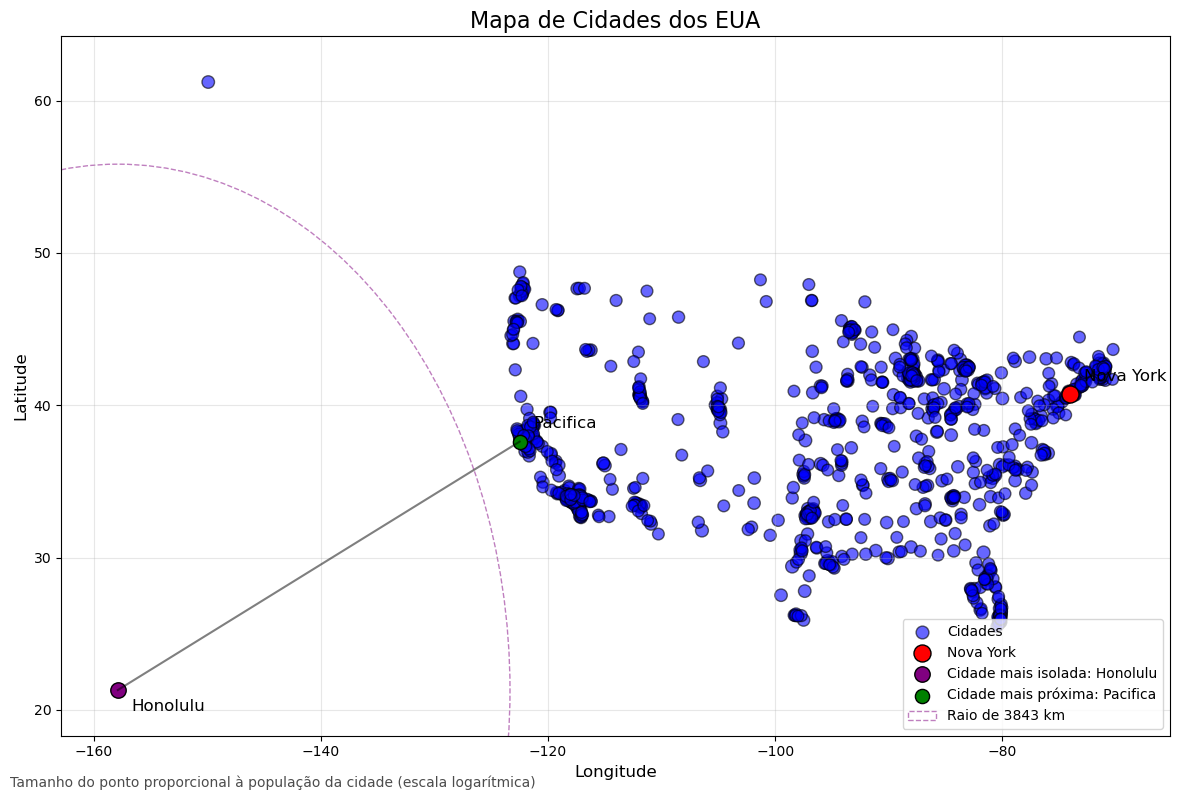


Novo mapa após remover a cidade isolada:


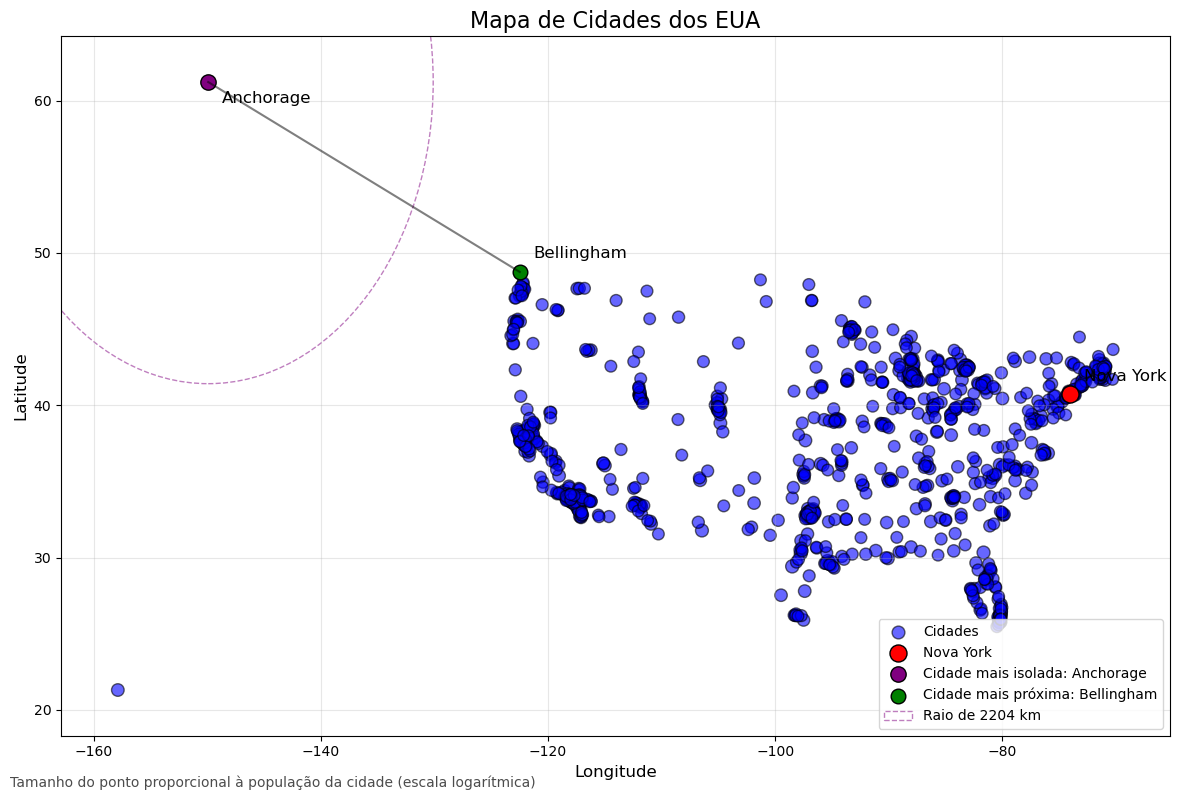

In [19]:
# Analisar o efeito de remover a cidade isolada
new_cities, new_distance_matrix, new_min_threshold, new_isolated_idx = analyze_network_without_isolated_city(
    cities, distance_matrix, isolated_city_idx)

In [20]:
def iterative_removal_analysis(cities, distance_matrix, num_removals=5):
    """
    Analisa o efeito de remover iterativamente as cidades mais isoladas
    
    Args:
        cities: Lista de objetos City original
        distance_matrix: Matriz de distâncias original
        num_removals: Número de cidades a serem removidas sequencialmente
    """
    # Preparar listas para armazenar dados históricos
    current_cities = cities.copy()
    current_matrix = distance_matrix.copy()
    history = []
    
    plt.figure(figsize=(12, 6))
    
    # Executar remoções iterativas
    for i in range(num_removals):
        # Encontrar a cidade isolada atual
        min_thresh, isolated_idx = find_minimum_full_connectivity_threshold(current_matrix)
        isolated_name = current_cities[isolated_idx].name
        
        # Armazenar dados históricos
        history.append({
            'iteration': i,
            'removed_city': isolated_name,
            'min_threshold': min_thresh
        })
        
        # Imprimir resultados desta iteração
        print(f"\nIteração {i+1}: Removendo {isolated_name}")
        print(f"Raio mínimo atual: {min_thresh:.2f} km")
        
        # Remover a cidade isolada
        new_cities = [city for j, city in enumerate(current_cities) if j != isolated_idx]
        
        # Atualizar matriz de distância
        n = current_matrix.shape[0]
        mask = np.ones(n, dtype=bool)
        mask[isolated_idx] = False
        new_matrix = current_matrix[mask][:, mask]
        
        # Atualizar para próxima iteração
        current_cities = new_cities
        current_matrix = new_matrix
        
        # Plotar resultados parciais para esta iteração
        plt.plot(range(1, i+2), [h['min_threshold'] for h in history], 
                'o-', linewidth=2, markersize=8)
        plt.annotate(f"{isolated_name}", 
                    (i+1, history[i]['min_threshold']), 
                    xytext=(10, 0), textcoords='offset points')
    
    # Completar o gráfico
    plt.title('Redução do Raio Mínimo com Remoções Iterativas de Cidades', fontsize=14)
    plt.xlabel('Número de Cidades Removidas', fontsize=12)
    plt.ylabel('Raio Mínimo (km)', fontsize=12)
    plt.grid(alpha=0.3)
    plt.xticks(range(1, num_removals+1))
    
    # Calcular estatísticas
    initial_threshold = history[0]['min_threshold']
    final_threshold = history[-1]['min_threshold']
    reduction = initial_threshold - final_threshold
    percent_reduction = (reduction / initial_threshold) * 100
    
    # Adicionar texto com estatísticas
    plt.figtext(0.5, 0.01, 
                f"Redução total: {reduction:.2f} km ({percent_reduction:.1f}%)\n"
                f"Cidades removidas: {', '.join([h['removed_city'] for h in history])}",
                ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    return history, current_cities, current_matrix


Iteração 1: Removendo Honolulu
Raio mínimo atual: 3842.71 km

Iteração 2: Removendo Anchorage
Raio mínimo atual: 2204.27 km

Iteração 3: Removendo Rapid City
Raio mínimo atual: 282.94 km

Iteração 4: Removendo Grand Junction
Raio mínimo atual: 261.36 km

Iteração 5: Removendo Casper
Raio mínimo atual: 228.20 km


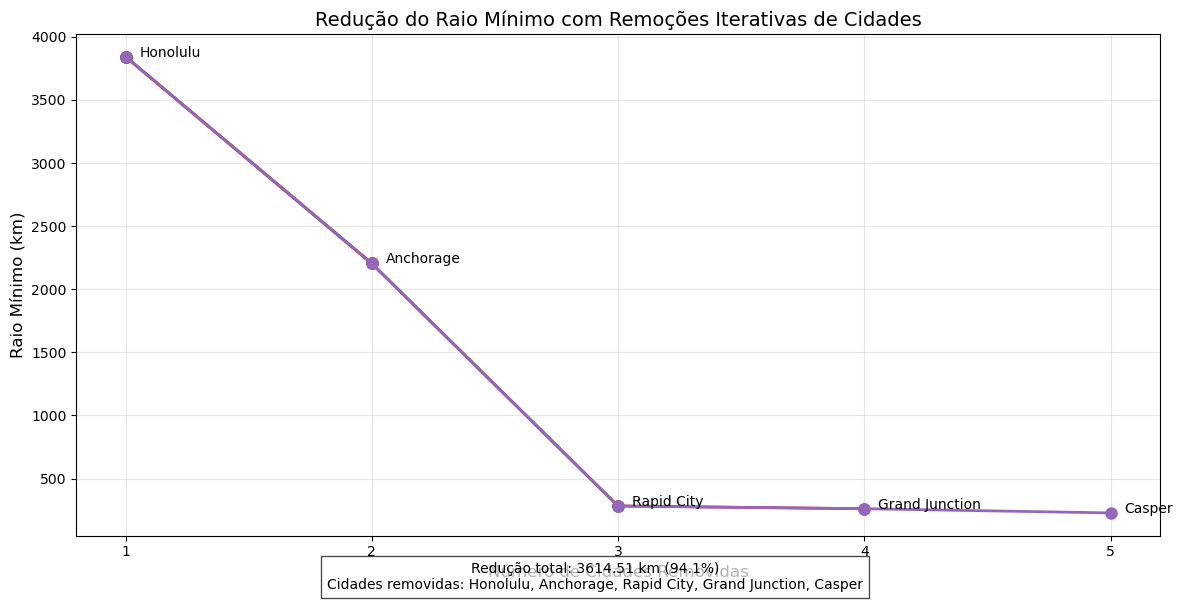

In [21]:
# Realizar análise iterativa removendo 5 cidades mais isoladas em sequência
removal_history, remaining_cities, remaining_matrix = iterative_removal_analysis(
    cities, distance_matrix, num_removals=5)

Removendo cidades: ['Honolulu', 'Anchorage']

Raio mínimo original: 3842.71 km
Cidade mais isolada original: Honolulu

Após remover Honolulu e Anchorage:
Novo raio mínimo: 282.94 km
Nova cidade mais isolada: Rapid City
Primeira conexão da nova cidade isolada: Casper a 282.94 km
Redução no raio mínimo: 3559.76 km (92.6%)


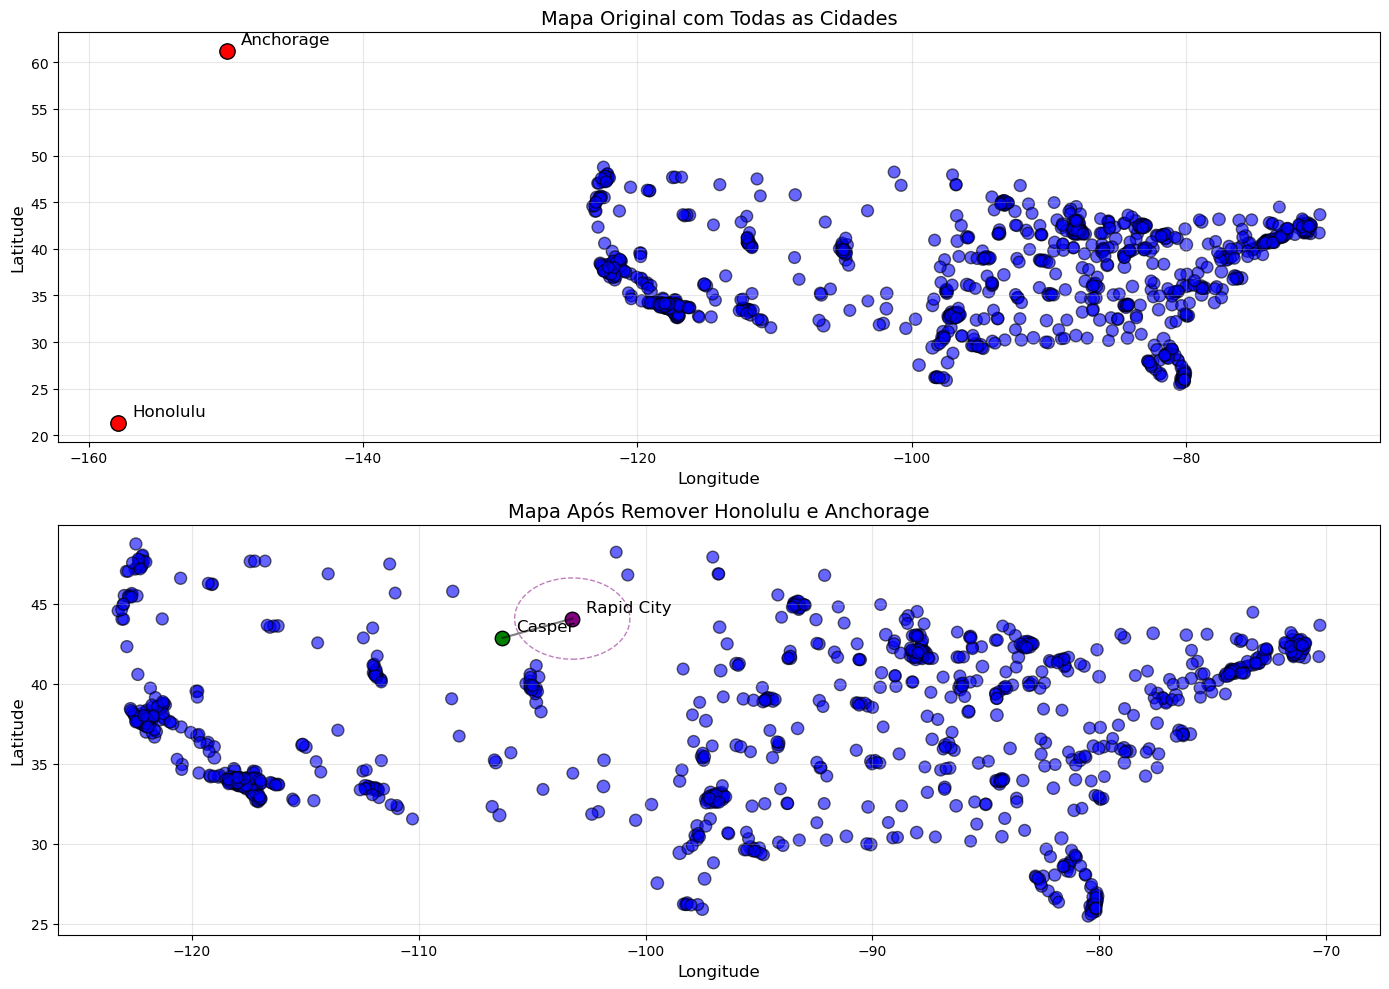


Análise iterativa após remoção inicial:

Iteração 1: Removendo Rapid City
Raio mínimo atual: 282.94 km

Iteração 2: Removendo Grand Junction
Raio mínimo atual: 261.36 km

Iteração 3: Removendo Casper
Raio mínimo atual: 228.20 km


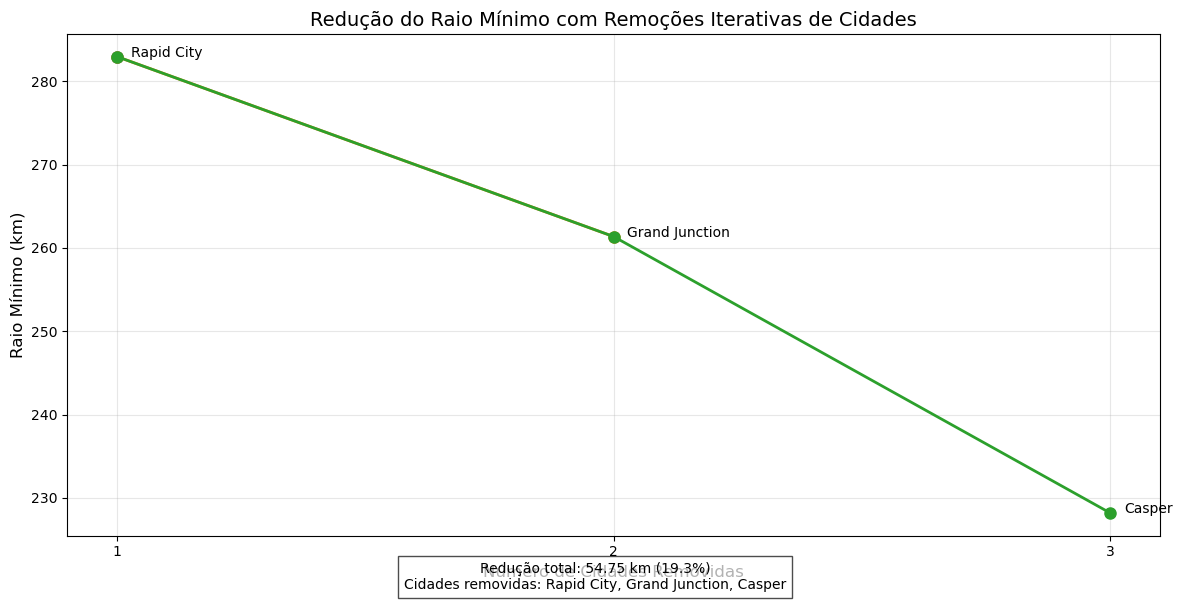

In [22]:
def analyze_network_without_specific_cities(cities, distance_matrix, city_names_to_remove=['Honolulu', 'Anchorage']):
    """
    Analisa a rede de cidades após remover cidades específicas (como Honolulu e Anchorage)
    
    Args:
        cities: Lista de objetos City
        distance_matrix: Matriz de distâncias original
        city_names_to_remove: Lista de nomes de cidades a serem removidas
    """
    # Encontrar índices das cidades a remover
    indices_to_remove = [i for i, city in enumerate(cities) if city.name in city_names_to_remove]
    
    if not indices_to_remove:
        print(f"Cidades especificadas não encontradas: {city_names_to_remove}")
        return cities, distance_matrix
        
    # Imprimir cidades que serão removidas
    print(f"Removendo cidades: {[cities[idx].name for idx in indices_to_remove]}")
    
    # Criar novas listas sem essas cidades
    mask = np.ones(len(cities), dtype=bool)
    for idx in indices_to_remove:
        mask[idx] = False
    
    new_cities = [city for i, city in enumerate(cities) if mask[i]]
    new_distance_matrix = distance_matrix[mask][:, mask]
    
    # Encontrar o novo threshold mínimo
    new_min_threshold, new_isolated_idx = find_minimum_full_connectivity_threshold(new_distance_matrix)
    new_isolated_city = new_cities[new_isolated_idx]
    
    # Encontrar a cidade mais próxima da nova cidade isolada
    new_second_idx = np.argmin([
        new_distance_matrix[new_isolated_idx, j] if new_isolated_idx != j else float('inf') 
        for j in range(len(new_cities))
    ])
    
    # Obter threshold da matriz original para comparação
    original_min_threshold, original_isolated_idx = find_minimum_full_connectivity_threshold(distance_matrix)
    
    # Imprimir resultados comparativos
    print(f"\nRaio mínimo original: {original_min_threshold:.2f} km")
    print(f"Cidade mais isolada original: {cities[original_isolated_idx].name}")
    
    print(f"\nApós remover {' e '.join([cities[idx].name for idx in indices_to_remove])}:")
    print(f"Novo raio mínimo: {new_min_threshold:.2f} km")
    print(f"Nova cidade mais isolada: {new_isolated_city.name}")
    print(f"Primeira conexão da nova cidade isolada: {new_cities[new_second_idx].name} " 
          f"a {new_distance_matrix[new_isolated_idx, new_second_idx]:.2f} km")
          
    # Calcular redução
    reduction = original_min_threshold - new_min_threshold
    print(f"Redução no raio mínimo: {reduction:.2f} km ({(reduction/original_min_threshold)*100:.1f}%)")
    
    # Criar visualização
    plt.figure(figsize=(14, 10))
    
    # Gráfico 1: Mapa original com todas as cidades
    plt.subplot(2, 1, 1)
    lats = [city.latitude for city in cities]
    longs = [city.longitude for city in cities]
    populations = np.array([city.population for city in cities])
    point_sizes = 10 + 90 * np.log(populations) / np.log(populations.max())
    
    plt.scatter(longs, lats, s=point_sizes, alpha=0.6, c='blue', edgecolor='black')
    
    # Destacar cidades a serem removidas
    for idx in indices_to_remove:
        plt.scatter(longs[idx], lats[idx], s=point_sizes[idx]*1.5, 
                   c='red', edgecolor='black')
        plt.annotate(cities[idx].name, 
                    (longs[idx], lats[idx]),
                    xytext=(10, 5), textcoords='offset points', fontsize=12)
    
    plt.title('Mapa Original com Todas as Cidades', fontsize=14)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.grid(alpha=0.3)
    
    # Gráfico 2: Novo mapa após remoção
    plt.subplot(2, 1, 2)
    new_lats = [city.latitude for city in new_cities]
    new_longs = [city.longitude for city in new_cities]
    new_populations = np.array([city.population for city in new_cities])
    new_point_sizes = 10 + 90 * np.log(new_populations) / np.log(new_populations.max())
    
    plt.scatter(new_longs, new_lats, s=new_point_sizes, alpha=0.6, c='blue', edgecolor='black')
    
    # Destacar nova cidade isolada
    plt.scatter(new_longs[new_isolated_idx], new_lats[new_isolated_idx], s=new_point_sizes[new_isolated_idx]*1.5, 
               c='purple', edgecolor='black')
    plt.annotate(new_cities[new_isolated_idx].name, 
                (new_longs[new_isolated_idx], new_lats[new_isolated_idx]),
                xytext=(10, 5), textcoords='offset points', fontsize=12)
                
    # Destacar sua cidade mais próxima
    plt.scatter(new_longs[new_second_idx], new_lats[new_second_idx], s=new_point_sizes[new_second_idx]*1.5, 
               c='green', edgecolor='black')
    plt.annotate(new_cities[new_second_idx].name, 
                (new_longs[new_second_idx], new_lats[new_second_idx]),
                xytext=(10, 5), textcoords='offset points', fontsize=12)
                
    # Desenhar a conexão
    plt.plot([new_longs[new_isolated_idx], new_longs[new_second_idx]], 
             [new_lats[new_isolated_idx], new_lats[new_second_idx]], 
             'k-', alpha=0.5)
             
    # Desenhar círculo aproximado
    radius_deg = new_min_threshold / 111.32
    circle = plt.Circle((new_longs[new_isolated_idx], new_lats[new_isolated_idx]), 
                       radius_deg, fill=False, color='purple', linestyle='--', alpha=0.5)
    plt.gca().add_patch(circle)
    
    plt.title(f'Mapa Após Remover {" e ".join([cities[idx].name for idx in indices_to_remove])}', fontsize=14)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Executar análise iterativa adicional
    print("\nAnálise iterativa após remoção inicial:")
    removal_history, remaining_cities, remaining_matrix = iterative_removal_analysis(
        new_cities, new_distance_matrix, num_removals=3)
    
    return new_cities, new_distance_matrix


# Reanalizar a rede removendo Honolulu e Anchorage
modified_cities, modified_distance_matrix = analyze_network_without_specific_cities(
    cities, distance_matrix, ['Honolulu', 'Anchorage'])

In [24]:
def calculate_min_radius_without_cities(cities, distance_matrix, cities_to_remove=['Honolulu', 'Anchorage']):
    """
    Calcula o raio mínimo para conectividade total após remover cidades específicas
    """
    # Encontrar índices das cidades a remover
    indices_to_remove = []
    for name in cities_to_remove:
        for i, city in enumerate(cities):
            if city.name == name:
                indices_to_remove.append(i)
                print(f"Encontrado {name} no índice {i}")
                break
    
    if len(indices_to_remove) != len(cities_to_remove):
        print("Aviso: Nem todas as cidades especificadas foram encontradas!")
    
    # Criar novas listas sem essas cidades
    mask = np.ones(len(cities), dtype=bool)
    for idx in indices_to_remove:
        mask[idx] = False
    
    new_cities = [city for i, city in enumerate(cities) if mask[i]]
    new_distance_matrix = distance_matrix[mask][:, mask]
    
    # Calcular novo raio mínimo
    new_min_threshold, new_isolated_idx = find_minimum_full_connectivity_threshold(new_distance_matrix)
    
    # Obter dados da cidade mais isolada após remoção
    isolated_city = new_cities[new_isolated_idx]
    
    # Encontrar a segunda cidade mais próxima
    second_idx = np.argmin([
        new_distance_matrix[new_isolated_idx, j] if new_isolated_idx != j else float('inf') 
        for j in range(len(new_cities))
    ])
    second_city = new_cities[second_idx]
    
    # Calcular o raio mínimo original para comparação
    orig_min_threshold, _ = find_minimum_full_connectivity_threshold(distance_matrix)
    
    print(f"\nResultados após remover {', '.join(cities_to_remove)}:")
    print(f"Raio mínimo original: {orig_min_threshold:.2f} km")
    print(f"Novo raio mínimo: {new_min_threshold:.2f} km")
    print(f"Redução: {orig_min_threshold - new_min_threshold:.2f} km ({(orig_min_threshold - new_min_threshold)/orig_min_threshold*100:.1f}%)")
    print(f"Nova cidade mais isolada: {isolated_city.name}")
    print(f"Conecta-se com: {second_city.name} a {new_distance_matrix[new_isolated_idx, second_idx]:.2f} km")
    
    return new_min_threshold, new_cities, new_distance_matrix

# Executar a análise
new_min_radius, new_cities_list, new_dist_matrix = calculate_min_radius_without_cities(
    cities, distance_matrix, ['Honolulu', 'Anchorage'])

Encontrado Honolulu no índice 53
Encontrado Anchorage no índice 62

Resultados após remover Honolulu, Anchorage:
Raio mínimo original: 3842.71 km
Novo raio mínimo: 282.94 km
Redução: 3559.76 km (92.6%)
Nova cidade mais isolada: Rapid City
Conecta-se com: Casper a 282.94 km


In [26]:
min_threshold, isolated_city_idx = find_minimum_full_connectivity_threshold(new_dist_matrix)
print(f"Raio mínimo para que todas as cidades estejam conectadas: {min_threshold:.2f} km")
print(f"A cidade mais isolada é {cities[isolated_city_idx].name}, que precisa de pelo menos {min_threshold:.2f} km para conectar-se")

# Encontrar com qual cidade esta cidade se conecta primeiro
second_city_idx = np.argmin([
    distance_matrix[isolated_city_idx, j] if isolated_city_idx != j else float('inf') 
    for j in range(len(cities))
])
print(f"A primeira conexão dela seria com {cities[second_city_idx].name}, a {distance_matrix[isolated_city_idx, second_city_idx]:.2f} km de distância")

Raio mínimo para que todas as cidades estejam conectadas: 282.94 km
A cidade mais isolada é Apple Valley, que precisa de pelo menos 282.94 km para conectar-se
A primeira conexão dela seria com Victorville, a 10.55 km de distância
